## Question-1

## Architecture

[INPUT - CONV - RELU - POOL - CONV - RELU - POOL - FC - FC - OUTPUT]. 

1. <b>INPUT</b> 32x32x3 will hold the raw pixel values of the image, which is an image of width 32, height 32, and with three color channels R,G,B.<br><br>

2. <b>CONV layer</b> will compute the output of neurons from the previous layer, each computing a dot product between their weights. This is done using filter with weights. This results in sparsely connected neurons and weight sharing between them. This may result in volume such as 32x32x12 if we decided to use 12 filters.<br><br>

3. <b>RELU layer</b> will apply an elementwise activation function, such as the max(0,x) thresholding at zero. This leaves the size of the volume unchanged (32x32x12).<br><br>

4. <b>POOL layer</b> will perform a downsampling operation along the spatial dimensions (width, height) i.e like a filter it will sample across the image and choose the maximum pixel among all. This results in volume such as 16x16x12.<br><br>

5. <b>Fully-Connected layer (FC)</b> will compute the class scores, resulting in volume of size 1x1x10, where each of the 10 numbers correspond to a class score, such as among the 10 categories of CIFAR-10. As with ordinary Neural Networks and as the name implies, each neuron in this layer will be connected to all the numbers in the previous volume.



### Activation Functions:
1. <b>Sigmoid(z): </b>$\dfrac{1}{1+\exp^{-z}}$<br><br>
2. <b>Tanh(z): </b>$\dfrac{2}{1+\exp^{-2z}}-1$<br><br>
3. <b>ReLU(z): </b><br>$z<=0, f(z) = 0$<br><br>$z>0, f(z)=z$<br><br>
where $z = w^Tx+b$ (w is the weight vector and b is the bias vector)


### Forward Propagation

Given an input layer and series of hidden layer (zero or more) and an output layer of an artifical neural network we can feed this network an image in the input layer. This further, with weights and biases of each connection between any two layers, is trained at every neuron in the next layer, with every neuron learning a specfic part of the image. Finally the ouput layer which on the basic understanding consists of neurons equivalent of all possible labels. The neuron that activates the most is our desired label.

<b>Steps:</b>
1. $z = w^Tx+b$ (w is the weight vector and b is the bias vector)
2. $a$ = $F(z)$ (where F is a funtion of z which Sigmoid,ReLu or tanh etc. to give a good distribution of real numbers)
3. Repeat steps 1 and 2 till the output layer.

In [1]:
import matplotlib.pyplot as plt
from scipy import ndimage, misc
import numpy as np
import pandas as pd

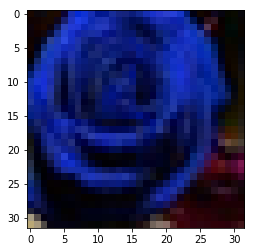

In [55]:
image = plt.imread('./rose.jpg','jpg')
plt.imshow(image)

In [3]:
#image = image.reshape((32,32,1))
print(image.T.shape)

(3, 32, 32)


In [57]:
class CNN: 
    def randomFilter(self,numberOfFilters,depth):
        randomList = []
        for i in range(0,numberOfFilters):
            randomList.append(np.random.randn(depth,5,5))  #changed depth to 0th axis
        return randomList
    
    def convolution(self,imageInput,filters,stride,activation):
        rowstride = 0
        colstride = 0
        listOfConvl = []
        convmat = []
        filterSize = 5
        for filt in filters:
            rowstride=0
            convmat = []
            while rowstride+filterSize <= imageInput.shape[1]: #changed from 0 to 1
                colstride = 0
                while colstride+filterSize <= imageInput.shape[2]: #changed from 1 to 2
                    mat = imageInput[:,rowstride:rowstride+filterSize,\
                                     colstride:colstride+filterSize]
                    convmat.append(np.sum(np.multiply(mat,filt)))
                    colstride+=stride
                rowstride+=stride
            convmat = np.array(convmat)
            convmat = self.activationFunc(convmat,activation)
            filteredmatshape = imageInput.shape[1]-np.array(filt).shape[1]+1 #changed 0 to 1
            convmat = convmat.reshape((filteredmatshape,filteredmatshape))
            listOfConvl.append(convmat)
        return listOfConvl 
    
    def maxpool(self,outputs,stride):
        rowstride = 0
        colstride = 0
        listOfConvl = []
        convmat = []
        poolSize = 2
        for output in outputs:
            rowstride=0
            convmat = []
            while rowstride+poolSize <= output.shape[0]:
                colstride = 0
                while colstride+poolSize <= output.shape[1]:
                    mat = output[rowstride:rowstride+poolSize,\
                                     colstride:colstride+poolSize]
                    convmat.append(np.max(mat))
                    colstride+=stride
                rowstride+=stride
            convmat = np.array(convmat)
            filteredmatshape = int(np.sqrt(convmat.shape[0]))
            convmat = convmat.reshape((filteredmatshape,filteredmatshape))
            listOfConvl.append(convmat)
        return listOfConvl
    
    
    def activationFunc(self,X,activation):
        if activation == 'relu':
            return X*(X>0)/10
        if activation == 'sigmoid':
            return 1/(1+np.exp(-X))
        if activation == 'tanh':
            return ((2/(1+np.exp(-2*X)))-1)
        if activation == 'softmax':
            X = X.transpose()
            for row in range(0,X.shape[0]):
                X[row] = X[row]-max(X[row])
                X[row] = np.exp(X[row])/sum(np.exp(X[row]))
            return(X.transpose())
        
    def feedforwardNN(self,a,layers,weights,biases,activation):
        counter = 1
        for weight,bias in zip(weights,biases):
            z = np.dot(weight,a)+bias
            if counter<layers:
                a = self.activationFunc(z,activation)
            else:
                a = self.activationFunc(z,'softmax')
                a = np.mean(np.array(a),axis=1)
            counter+=1
        return a
            
    def showImage(self,imageInput):
        a = plt.figure(figsize=(50,50))
        for i in range(0,imageInput.shape[0]):
            newImage = imageInput[i].T
            #print(newImage.shape)
            b = a.add_subplot(1,imageInput.shape[0],i+1)
            b.imshow(newImage)
        plt.show()
            
    def feedforward(self,imageInput,numberOfFilters,NNlayers,activation='relu'):
        #strides is an array of strides at every convl layer 
        convStride = 1
        poolStride = 2
        numOfLayers = len(numberOfFilters)
        for ind in range(0,numOfLayers):
            #Convolution
            #print("Input Layer",imageInput.shape)
            depth = imageInput.shape[0]  #changed from 2 to 0
            filters = self.randomFilter(numberOfFilters[ind],depth)
            outputs = self.convolution(imageInput,filters,convStride,activation)
            self.showImage(np.array(outputs))
            #MaxPool
            maxoutputs = self.maxpool(outputs,poolStride)
            imageInput = np.array(maxoutputs)
            self.showImage(imageInput)
            #imageInput = imageInput
        #print("Input Layer",imageInput.shape)
        
        #Flatten
        pixels = imageInput.shape[0] * imageInput.shape[1] * imageInput.shape[2]
        imageInput = imageInput.reshape((1,pixels))
        #print("Flattened",imageInput.shape)
        
        #FeedForwardNN
        layers = len(NNlayers)  #Number of layers
        NNlayers.insert(0,imageInput.shape[0])
        biases = [np.random.randn(i,1) for i in NNlayers[1:]]  #Init Bias
        weights = [np.random.randn(i,j) for i,j in zip(NNlayers[1:],NNlayers[:-1])]
        output = self.feedforwardNN(imageInput,layers,weights,biases,activation)
        print("Probability: ",output)

Images in odd rows: Convolutions
Images in even rows: Corresponding Max-pool


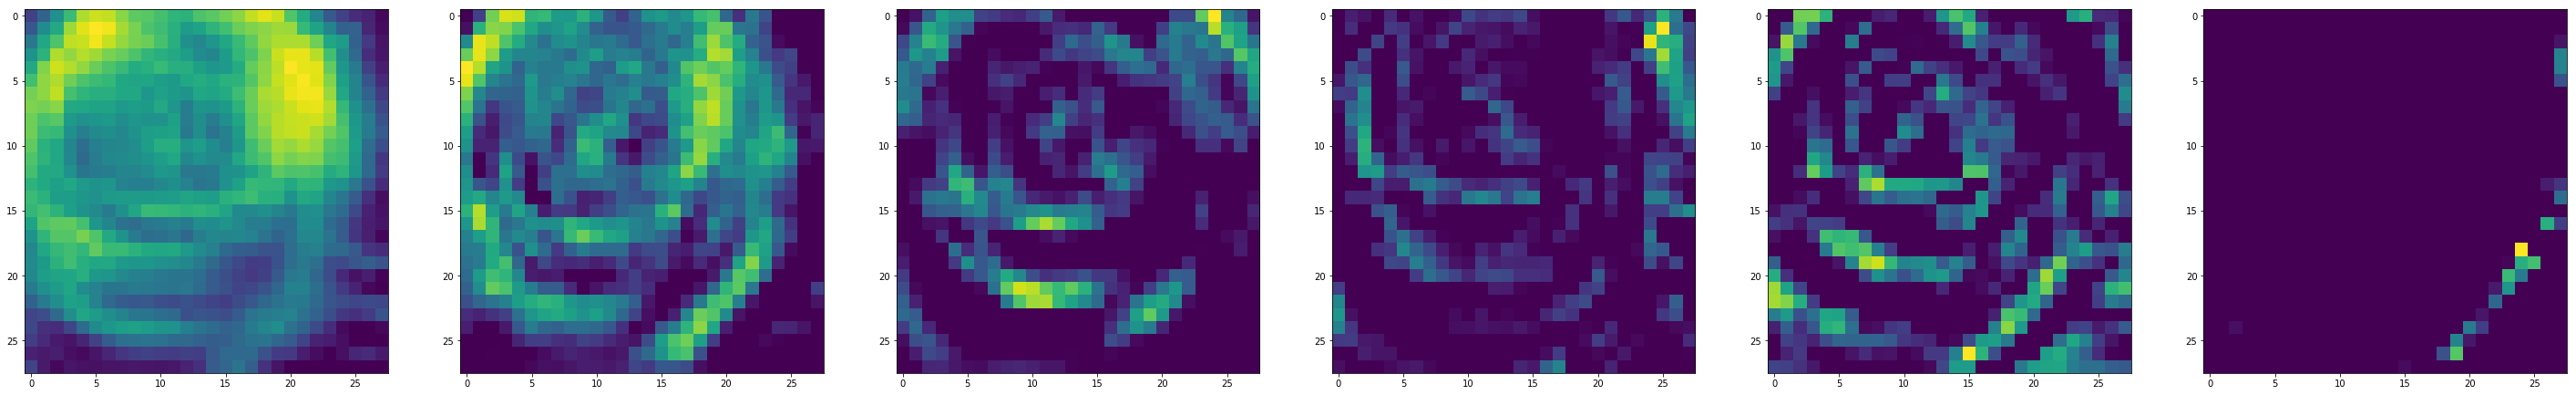

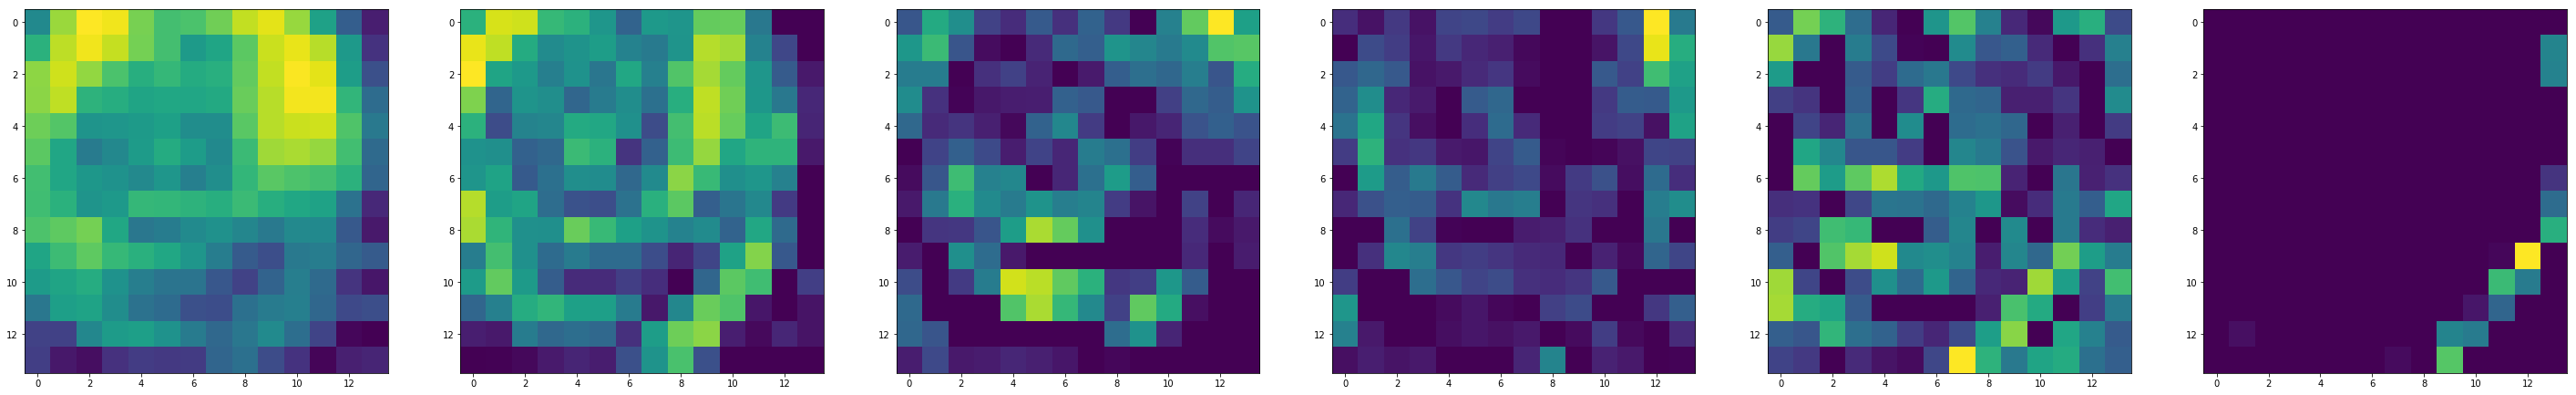

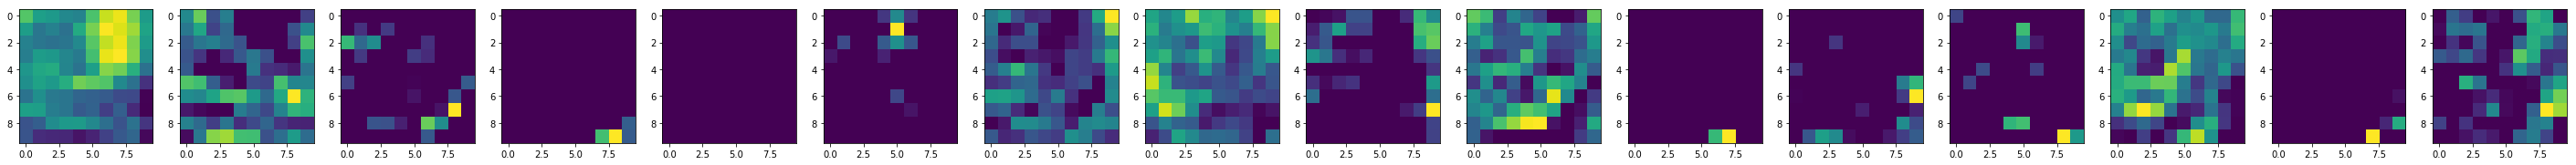

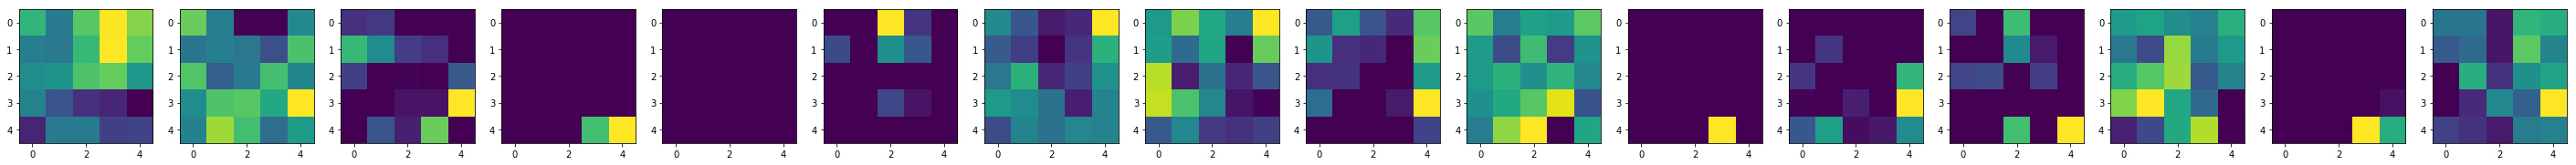

Probability:  [3.02867483e-03 4.74349479e-02 1.96490353e-02 1.34281999e-01
 6.43924460e-03 7.71863887e-02 1.57198172e-02 1.13440558e-01
 1.75278756e-04 5.82644055e-01]


In [58]:
a = CNN()
print("Images in odd rows: Convolutions\nImages in even rows: Corresponding Max-pool")
a.feedforward(image.T,[6,16],[120,84,10],activation='relu')

## Question-2

### 1. What are the number of parameters in 1st convolutional layers ?

<b>Filter dimension:</b> 5x5x3<br>
<b>Number of Filters:</b> 6<br>

<b>Number of updatable weights :</b> 5x5x3x6 = 450<br>
<b>Number of biases:</b> 6<br>
<b>Number of parameters:</b> weights + parameters = 456

### 2. What are the number of parameters in pooling operation? 
No updatable weights and biases in pooling, thus number of parameters is zero.

### 3. Which of the following operations contain most number of parameters?
<b>(a) conv (b) pool (c) Fully connected layer (FC) (d) Activation Functions </b>

<b>Number of parameters in each layer:</b><br>
<b>Convolution Layer 1:</b> 456 (From above) <br>
<b>Convolution Layer 2:</b> 5x5x6x16 + 16 = 2416 [weights + biases]<br>
<b>Fully connected Layer (Flattened):</b> 5x5x16x120 + 120  = 48120[weights+biases]<br>
<b>Activation Functions:</b> No parameters

It's clear from above that the <b>Fully Connected Layer has more number parameter than any layer</b>.

### 4. Which operation consume most amount of memory?
<b>(a) initial convolution layers (b) fully connected layers at the end</b>

The memory depends on both the number of parameters and the space to store images (or pixels) at every layer.<br>
In the <b>initial convolution layers</b> the number of parameter is 456 and the images generated are 28x28x6 which is 4704.<br>Thus total memory is 456 + 4704 = <b>5160</b>.

In the <b>first fully connected layer</b> at the end we have 48120 parameters +  space for pixels. This itself extremely large. Also in the following fully connected layers we have 400x84 + 84x120 [$W^T$a+b + weights] which is also extremely huge, <b>thus fully connected layers consume more memory.</b> 

### 5. Try different activation functions and describe observations.

#### Tanh

Tanh
Images in odd rows: Convolutions
Images in even rows: Corresponding Max-pool


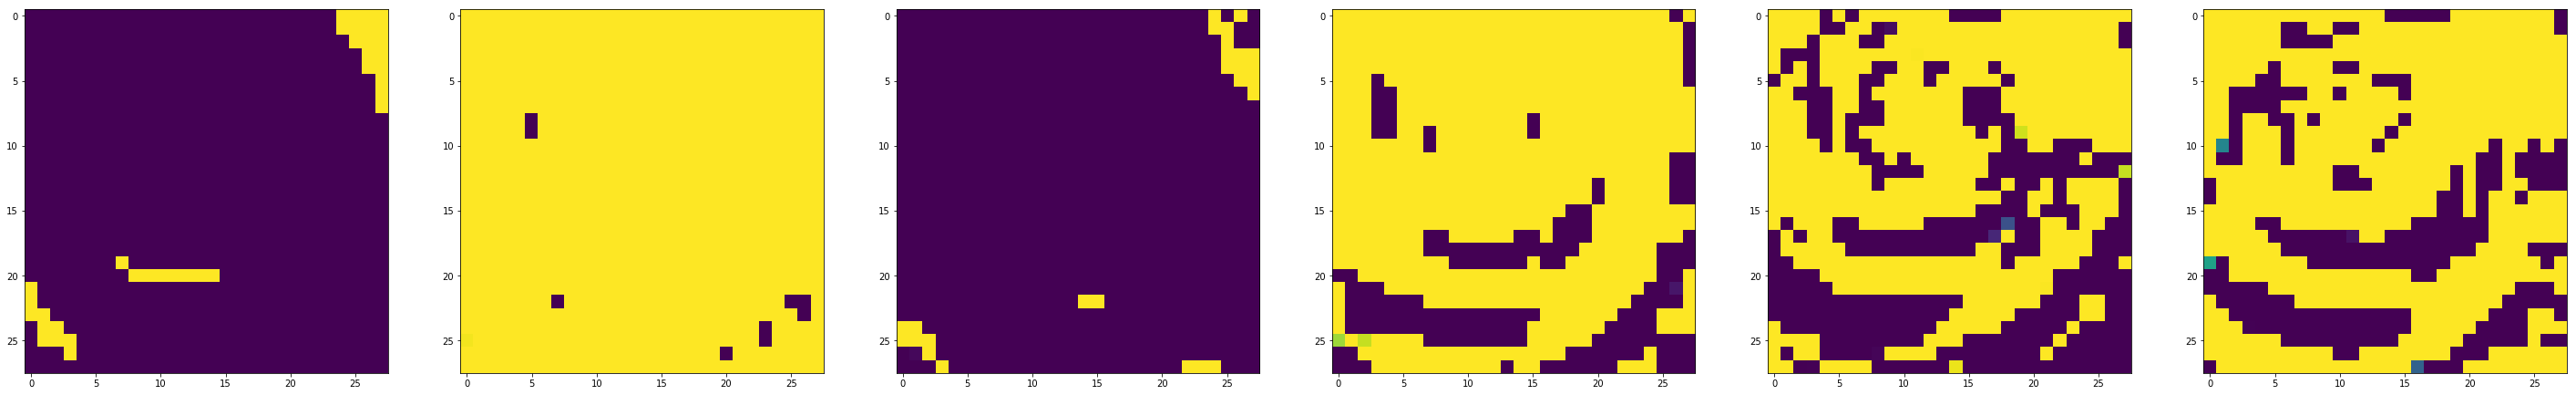

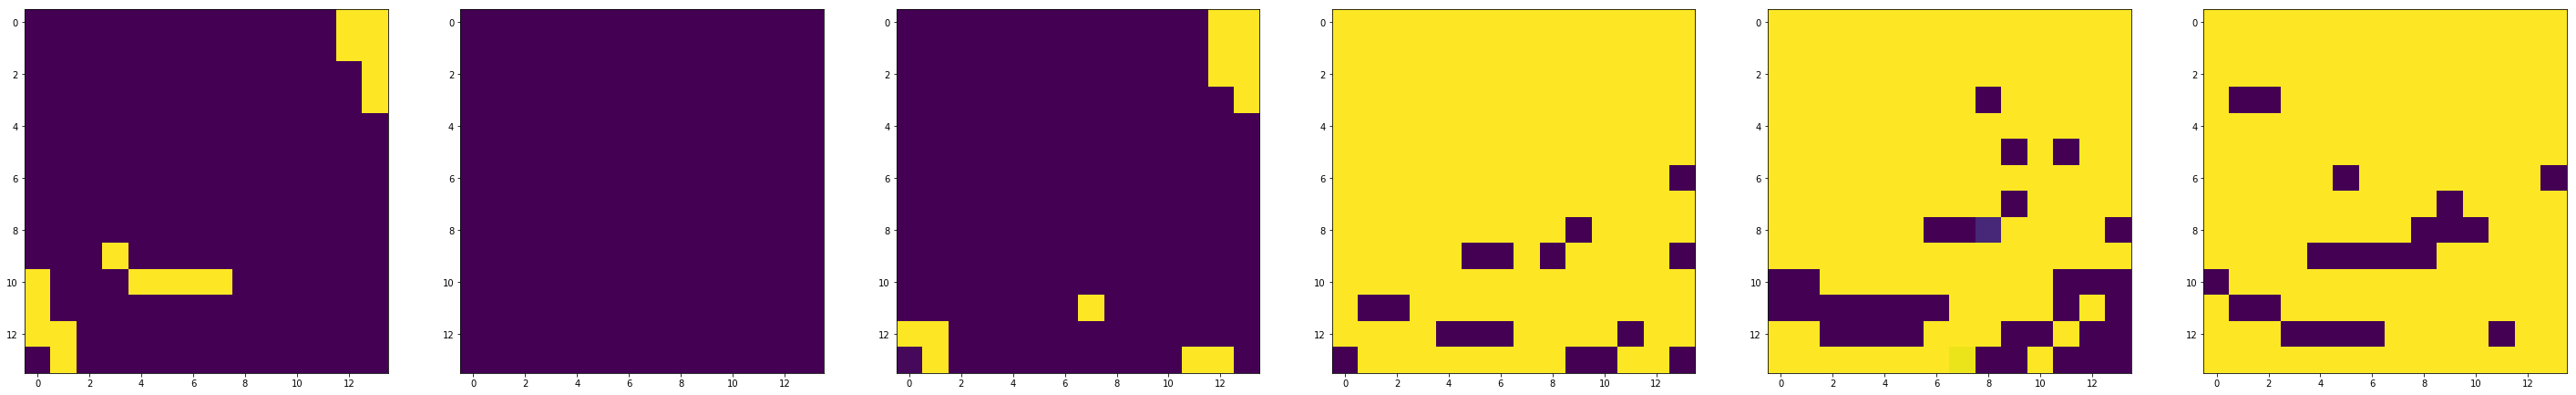

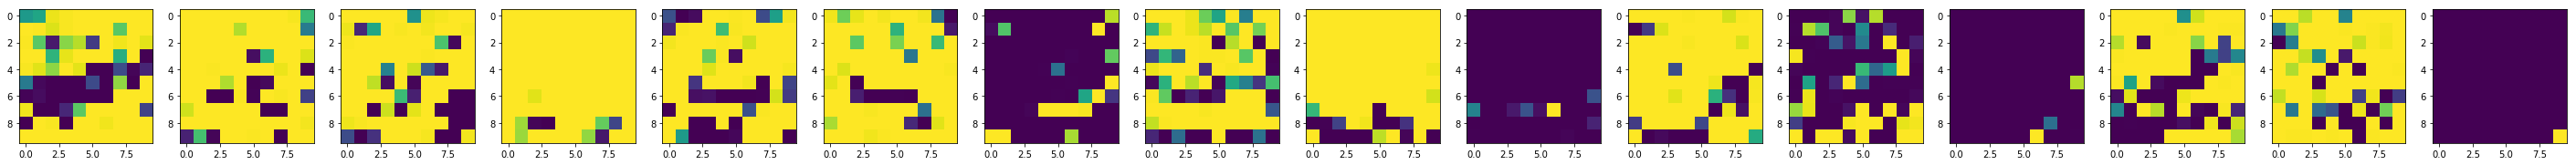

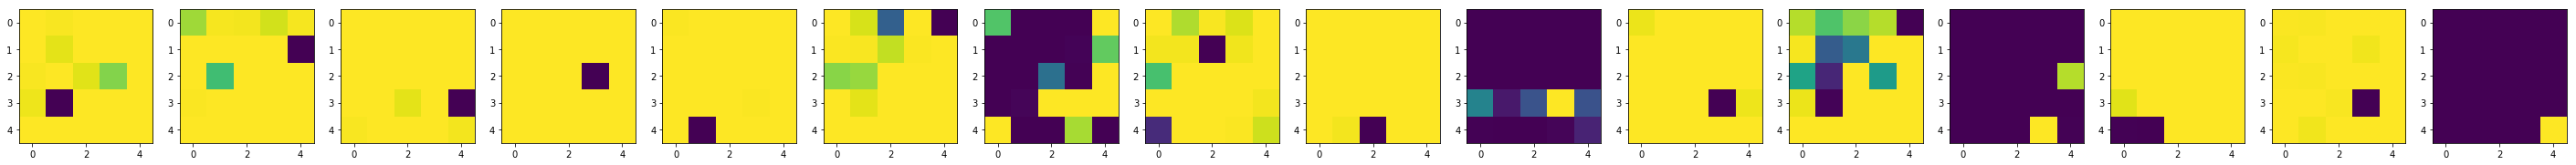

Probability:  [2.80531230e-06 4.39632375e-08 3.87340731e-03 2.44666895e-01
 9.71139378e-05 2.68682271e-02 2.14263870e-06 5.96622887e-03
 4.03774375e-05 7.18482758e-01]


In [59]:
print("Tanh")
a = CNN()
print("Images in odd rows: Convolutions\nImages in even rows: Corresponding Max-pool")
a.feedforward(image.T,[6,16],[120,84,10],activation='tanh')

#### Sigmoid

Sigmoid
Images in odd rows: Convolutions
Images in even rows: Corresponding Max-pool


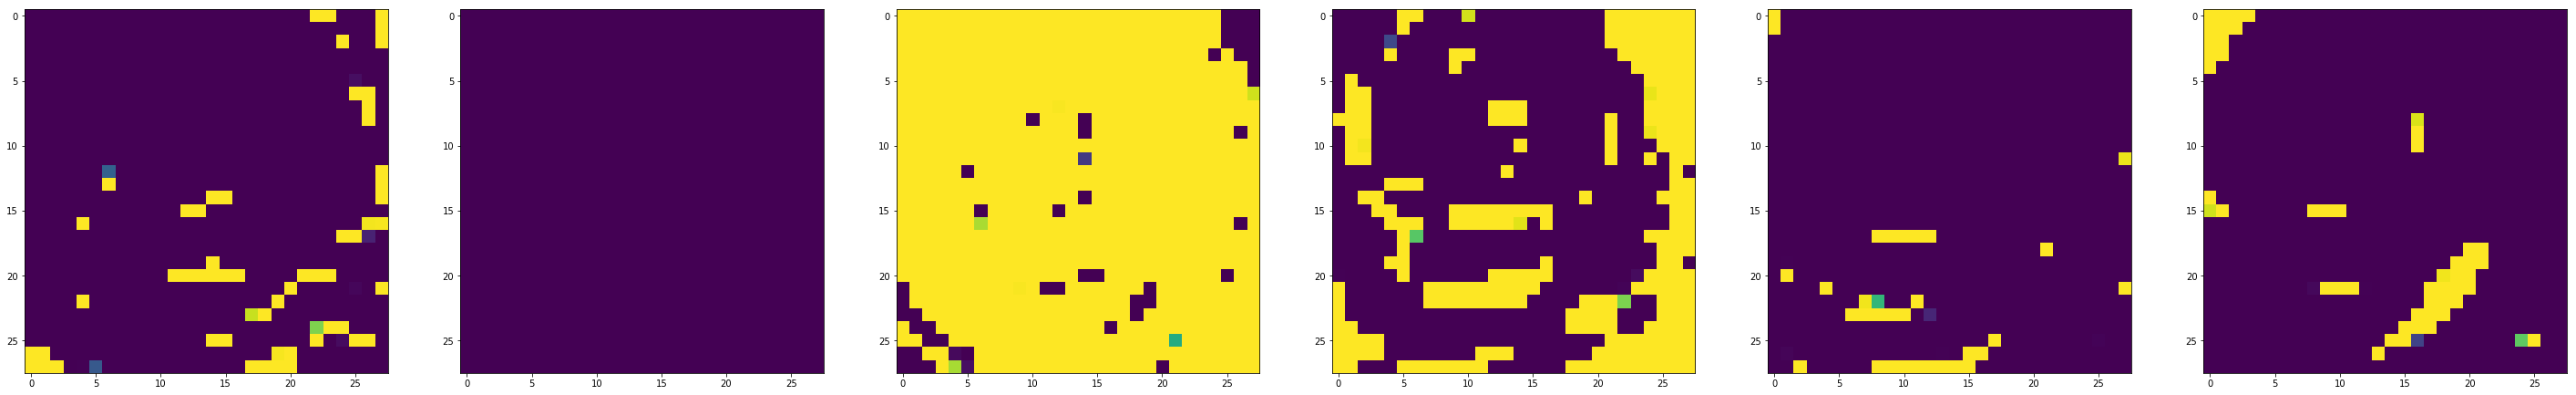

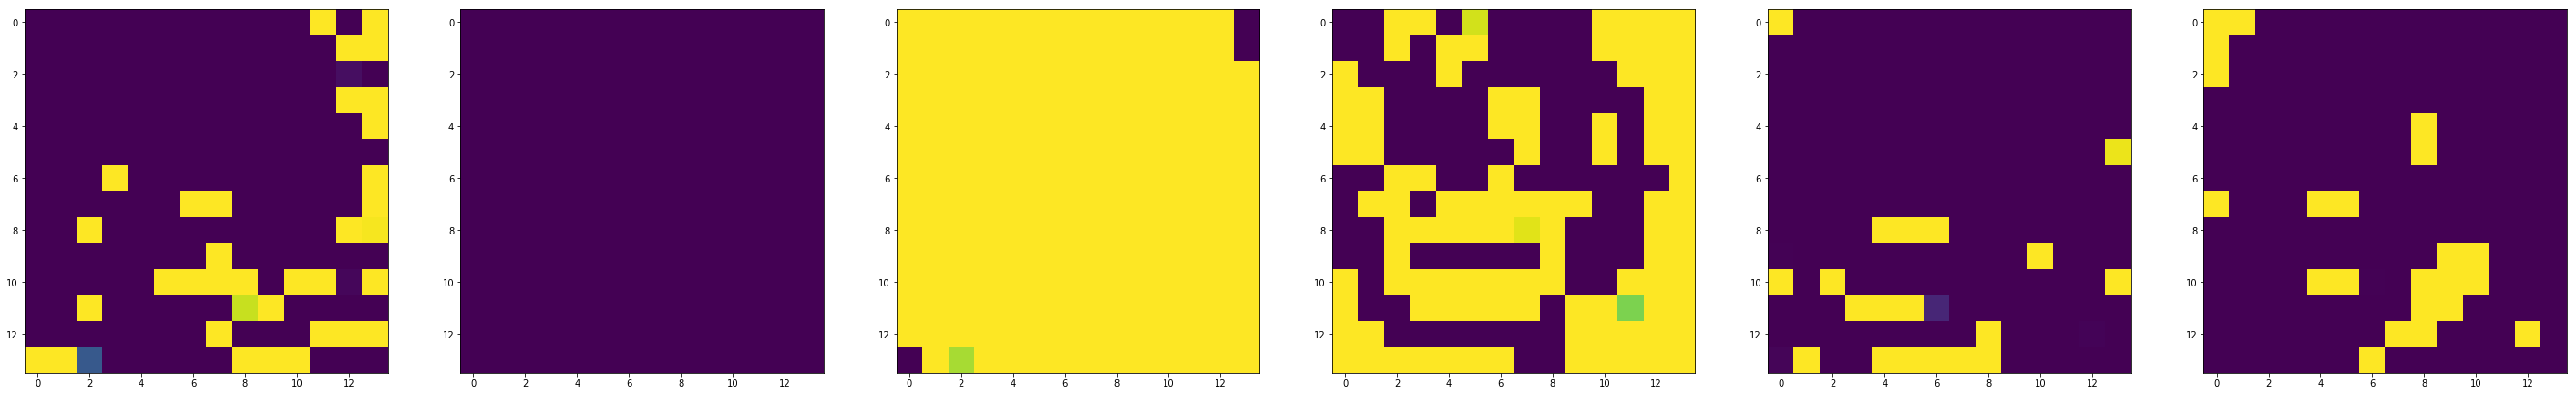

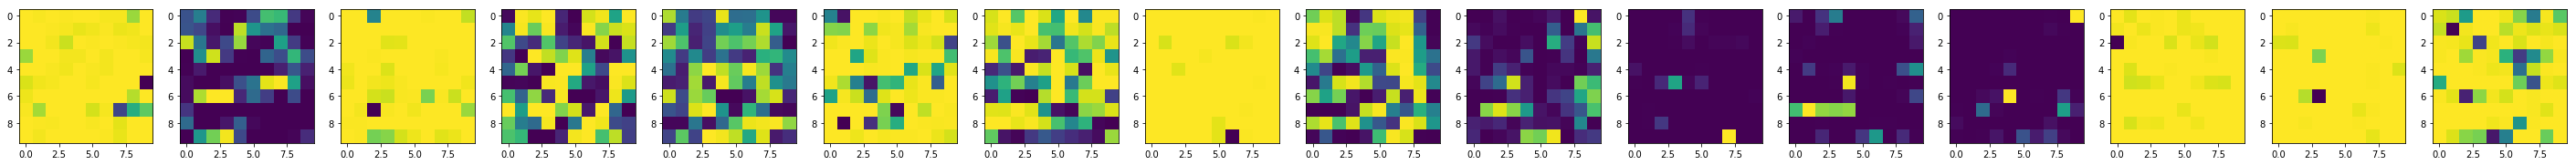

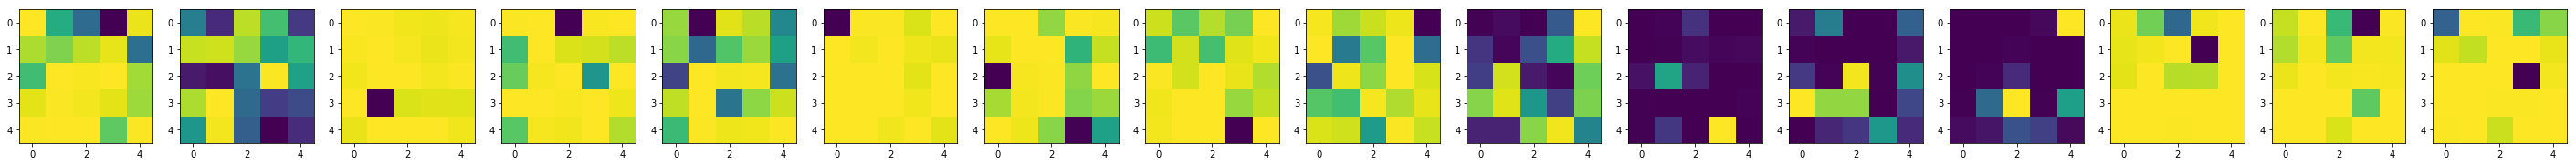

Probability:  [3.53274485e-06 6.08906523e-02 6.74305028e-05 8.04227692e-01
 1.00181898e-02 2.16831843e-08 2.15455573e-02 3.04438610e-03
 2.35563977e-07 1.00202302e-01]


In [60]:
print("Sigmoid")
a = CNN()
print("Images in odd rows: Convolutions\nImages in even rows: Corresponding Max-pool")
a.feedforward(image.T,[6,16],[120,84,10],activation='sigmoid')

### Observations:

<b>ReLu:</b> Nullifies negative values, thus gives a sharper edge in most scenario. But nullifies the entire image if most values are negative.<br>

<b>Sigmoid</b> Not very useful most of the times as even the negative values gets mapped between 0 to 1 and does not have sharp contrast in color.But in on of the image there is a good contrast to detect edges.<br>

<b>Tanh</b> Not very useful as both negative values and positive values are equally plotted and thus difficult to get a proper edge.